В данных 54 магазина и 33 семейства продуктов.                     
Временной ряд тренировочных данных с 01.01.2013 по 15.08.2017.              
Временной ряд тестовых данных для submition составляет 16 дней после последней даты тренировочных данных: с 16.08.2017 по 31.08.2017.                   
                                 
Нужно составить прогноз продаж для каждого из семейств продуктов в каждом из магазинов.     
                             
В отдельном ноутбуке проведен Feature engineering и сформированы необходимые датасеты.
                                
**Текущие датасеты**                   
1. final_featured_data - объединенные данные test и train с новыми признаками, отобранными по значимости.
2. zero_prediction - данные тех товаров, которые не продавались в конкретном магазине с начала 2013 года, исходя из чего можно предположить, что данные товары не будут продаваться в ближайшие 16 дней. Этот датасет мы будем объединять с предсказанными данными перед отправкой в submit.           
3. fuller_not_stat - не стационарные по результатам подсчета критерия Дикки-Фуллера ряды из числа рядов "магазин+семейство товаров"

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from tqdm.auto import tqdm

In [2]:
from fbprophet import Prophet

# 1. Import Data

In [3]:
# Import
df = pd.read_csv("../input/featured-data-with-imp-feat/final_featured_data.csv")
zero_prediction = pd.read_csv("../input/zero-prediction/zero_prediction.csv")
fuller_result = pd.read_csv("../input/fuller-result/fuller_not_stat.csv")

# Datetime
df["date"] = pd.to_datetime(df.date)

zero_prediction = zero_prediction.set_index(['store_nbr', 'family', 'date']).sort_index()
d_train = df[df.date<'2017-08-16'].copy()
d_test = df[df.date>='2017-08-16'].copy()

In [4]:
d_train.sample(2)

,family,store_nbr,date,id,sales,season,quarter,week_of_month,year,day_of_week,month,day_of_month,onpromotion,week_of_year,day_of_year
2641876,SEAFOOD,17,2014-06-22,955448,11.0,2,2,4,2014,6,6,22,0.0,25,173
577051,CLEANING,31,2015-05-20,1545793,1096.0,1,2,3,2015,2,5,20,2.0,21,140


In [5]:
d_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2698648 entries, 0 to 2698647
Data columns (total 15 columns):
 #   Column         Dtype         
---  ------         -----         
 0   family         object        
 1   store_nbr      int64         
 2   date           datetime64[ns]
 3   id             int64         
 4   sales          float64       
 5   season         int64         
 6   quarter        int64         
 7   week_of_month  int64         
 8   year           int64         
 9   day_of_week    int64         
 10  month          int64         
 11  day_of_month   int64         
 12  onpromotion    float64       
 13  week_of_year   int64         
 14  day_of_year    int64         
dtypes: datetime64[ns](1), float64(2), int64(11), object(1)
memory usage: 329.4+ MB


In [6]:
# Переименовываем столбцы для Prophet
d_train.columns = ['family', 'store_nbr', 'ds', 'id', 'y', 'season', 'quarter',
       'week_of_month', 'year', 'day_of_week', 'month', 'day_of_month',
       'onpromotion', 'week_of_year', 'day_of_year']

# Метрики

In [7]:
def compute_metrics(real, forecast):
    result = {}
    real=np.array(real)
    forecast=np.array(forecast)
    result['MSE'] = round(((real-forecast)**2).mean(),4)
    result['RMSE'] = round((((real-forecast)**2)**(1/2)).mean(),4)
    mape_list = []
    for i in range(len(real)):
        if real[i] == 0:
            mape_list.append(0)
        else:
            mape_list.append(abs(real[i]-forecast[i])/real[i])
        
    result['MAPE'] = round(np.mean(mape_list),4)
    result['SMAP'] = round(2.0 * np.mean(np.abs(forecast - real) / (np.abs(forecast) + np.abs(real))),4)
    return pd.Series(result)

# Validation

In [8]:
valid_peiod= 15
# train = d_train[d_train.ds<(d_train.ds.max() - timedelta(days = valid_peiod))]
# valid = d_train[d_train.ds>=(d_train.ds.max() - timedelta(days = valid_peiod))]

In [9]:
d_train.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

# Prophet for one ts

Initial log joint probability = -25.0712
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2543.71   1.03679e-05       61.4386      0.2589      0.2589      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       2543.71   9.37589e-09       62.5507     0.04931     0.04931      211   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
metrics: 
 MSE     5.8709
RMSE    1.9949
MAPE    0.7771
SMAP    0.4939
dtype: float64


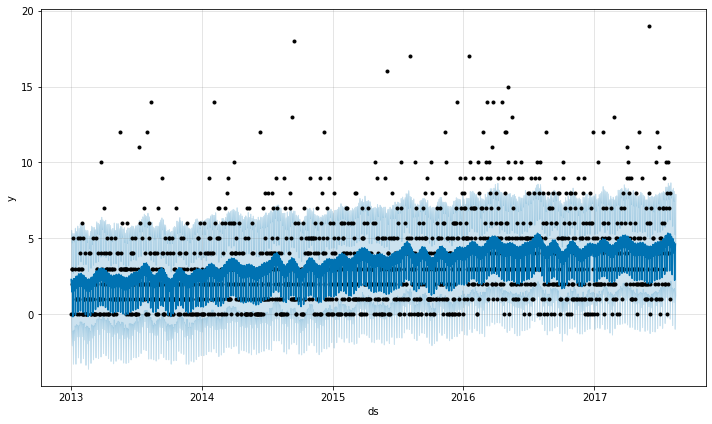

In [10]:
# simple prophit
model = Prophet()
f_train = d_train.loc[(d_train.family == 'AUTOMOTIVE') & (d_train.store_nbr == 1),['ds','y']].copy()
train = f_train[:-valid_peiod].copy()
model.fit(train)
future = model.make_future_dataframe(periods=valid_peiod)
forecast = model.predict(future)
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(f_train.set_index('ds'))
metrics = compute_metrics(cmp_df.loc['2017-08-01':'2017-08-15','y'], cmp_df.loc['2017-08-01':'2017-08-15','yhat'])
print('metrics: \n', metrics)
fig = model.plot(forecast)

Initial log joint probability = -25.9402
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2527.5     0.0269313       155.445      0.6239      0.6239      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2538.28   4.02534e-06       86.2993     0.06859      0.9338      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     267       2538.29   9.63981e-08       57.0186       0.334       0.334      339   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
metrics: 
 MSE     5.8948
RMSE    2.1312
MAPE    0.9551
SMAP    0.5123
dtype: float64


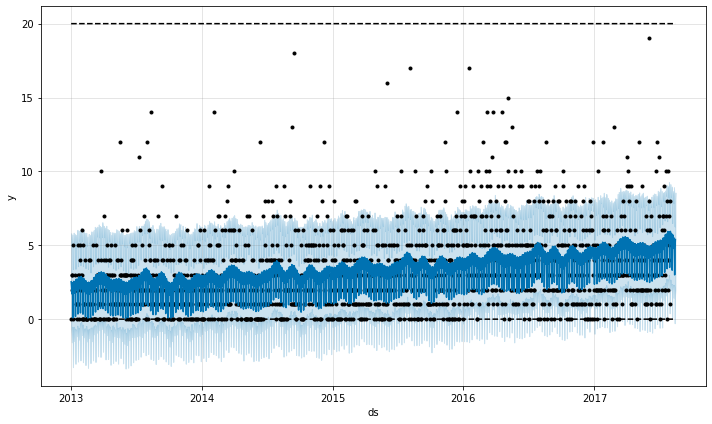

In [11]:
# логистический prophit с верхней и нижней границей
model = Prophet(growth='logistic')
f_train = d_train.loc[(d_train.family == 'AUTOMOTIVE') & (d_train.store_nbr == 1),['ds','y']].copy()
train = f_train[:-valid_peiod].copy()
train['cap'] = 20
train['floor'] = 0

model.fit(train)
future = model.make_future_dataframe(periods=valid_peiod)
future['cap'] = 20
future['floor'] = 0
forecast = model.predict(future)
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(f_train.set_index('ds'))
metrics = compute_metrics(cmp_df.loc['2017-08-01':'2017-08-15','y'], cmp_df.loc['2017-08-01':'2017-08-15','yhat'])
print('metrics: \n', metrics)
fig = model.plot(forecast)

Судя по метрикам, прогноз ухудшился

Initial log joint probability = -25.0712
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2554.56    0.00548662       11.4138           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       2555.34   0.000176712       21.8807   1.202e-05       0.001      237  LS failed, Hessian reset 
     199        2555.5   0.000672202       12.6438       0.606       0.606      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2555.91    0.00068952       11.9253      0.8368      0.8368      413   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     307       2555.92    0.00010009       9.56428   3.336e-06       0.001      456  LS failed, Hessian reset 
     399       2556.02   0.000298141       17.5344           1           1      579   
    Iter      log pro

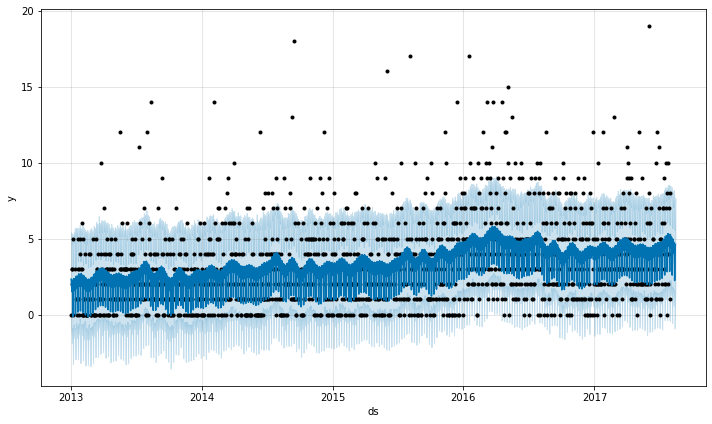

In [12]:
# изменение гибкости тренда prophit (по умолчанию changepoint_prior_scale=0.05)
model = Prophet(changepoint_prior_scale=0.5)
f_train = d_train.loc[(d_train.family == 'AUTOMOTIVE') & (d_train.store_nbr == 1),['ds','y']].copy()
train = f_train[:-valid_peiod].copy()
model.fit(train)
future = model.make_future_dataframe(periods=valid_peiod)
forecast = model.predict(future)
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(f_train.set_index('ds'))
metrics = compute_metrics(cmp_df.loc['2017-08-01':'2017-08-15','y'], cmp_df.loc['2017-08-01':'2017-08-15','yhat'])
print('metrics: \n', metrics)
fig = model.plot(forecast)

Увеличение гибкости не дает прироста относительно простой модели.

In [13]:
holidays = pd.read_csv("../input/store-sales-time-series-forecasting/holidays_events.csv")
holidays["date"] = pd.to_datetime(holidays.date)
holidays.sample(3)

,date,type,locale,locale_name,description,transferred
233,2016-04-29,Event,National,Ecuador,Terremoto Manabi+13,False
261,2016-07-03,Holiday,Local,El Carmen,Cantonizacion de El Carmen,False
320,2017-07-23,Holiday,Local,Cayambe,Cantonizacion de Cayambe,False


In [14]:
holidays_pf = holidays[['date', 'type']].copy()
holidays_pf.columns = ['ds', 'holiday']

In [15]:
holidays_pf

,ds,holiday
0,2012-03-02,Holiday
1,2012-04-01,Holiday
2,2012-04-12,Holiday
3,2012-04-14,Holiday
4,2012-04-21,Holiday
...,...,...
345,2017-12-22,Additional
346,2017-12-23,Additional
347,2017-12-24,Additional
348,2017-12-25,Holiday


Initial log joint probability = -25.0712
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2551.4   6.94404e-06        55.388      0.2784           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126        2551.4     8.964e-08        61.363      0.2943           1      164   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
metrics: 
 MSE     5.6498
RMSE    1.9843
MAPE    0.7752
SMAP    0.4935
dtype: float64


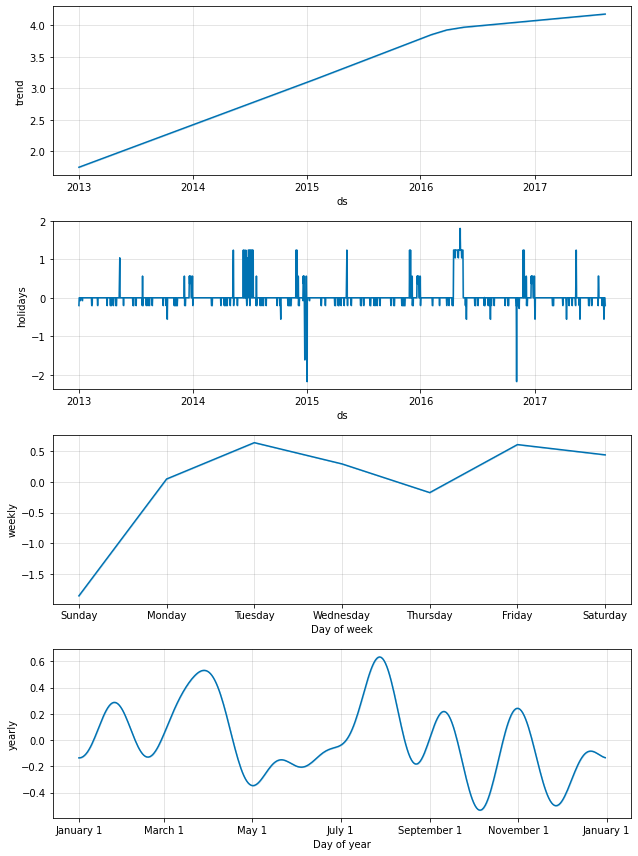

In [16]:
# prophit with holidays
model = Prophet(holidays=holidays_pf)
f_train = d_train.loc[(d_train.family == 'AUTOMOTIVE') & (d_train.store_nbr == 1),['ds','y']].copy()
train = f_train[:-valid_peiod].copy()
model.fit(train)
future = model.make_future_dataframe(periods=valid_peiod)
forecast = model.predict(future)
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(f_train.set_index('ds'))
metrics = compute_metrics(cmp_df.loc['2017-08-01':'2017-08-15','y'], cmp_df.loc['2017-08-01':'2017-08-15','yhat'])
print('metrics: \n', metrics)
fig = model.plot_components(forecast)

Незначительное улучшение MSE и RMSE по сравнению с simple prophet.

Initial log joint probability = -25.0712
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      83       2546.45   0.000440864       86.2323   4.553e-06       0.001      145  LS failed, Hessian reset 
      99       2546.49   1.83183e-06       69.1237       0.197       0.197      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       2546.63   0.000950528       89.9597   9.397e-06       0.001      261  LS failed, Hessian reset 
     199       2546.69   1.88601e-06       66.3129           1           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2546.72   1.81986e-06       58.6961           1           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     307       2546.72   1.85389e-07       67.8284      0.1974           1      461   
Optimization terminat

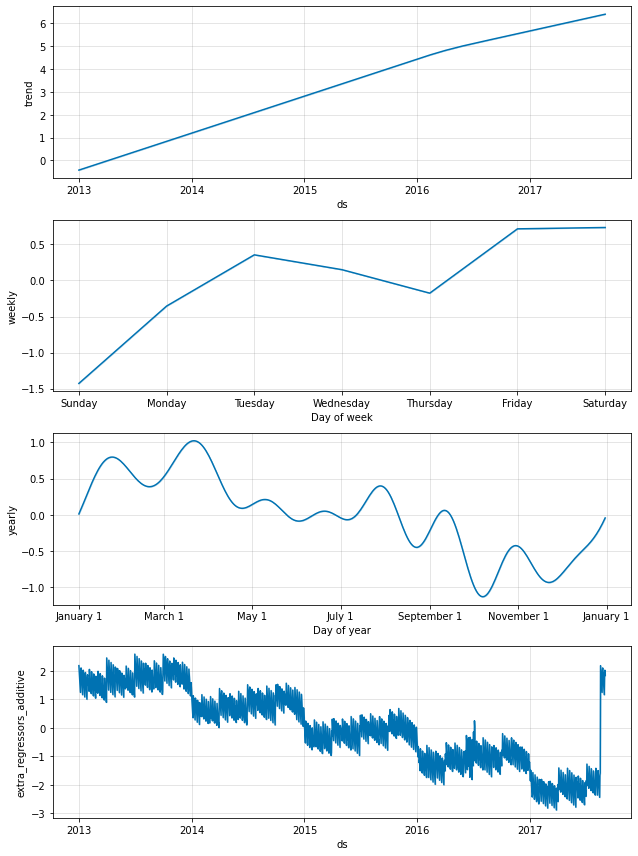

In [17]:
# добавление признаков prophit
model = Prophet()
model.add_regressor('season')
model.add_regressor('quarter')
model.add_regressor('week_of_month')
model.add_regressor('year')
model.add_regressor('day_of_week')
model.add_regressor('month')
model.add_regressor('day_of_month')
model.add_regressor('onpromotion')
model.add_regressor('week_of_year')
model.add_regressor('day_of_year')
f_train = d_train.loc[(d_train.family == 'AUTOMOTIVE') & (d_train.store_nbr == 1),['ds','y','season', 'quarter',
       'week_of_month', 'year', 'day_of_week', 'month', 'day_of_month',
       'onpromotion', 'week_of_year', 'day_of_year']].copy()
train = f_train[:-valid_peiod].copy()
model.fit(train)
future = model.make_future_dataframe(periods=valid_peiod+16)
future[['season', 'quarter',
       'week_of_month', 'year', 'day_of_week', 'month', 'day_of_month',
       'onpromotion', 'week_of_year', 'day_of_year']]= d_train[['season', 'quarter',
       'week_of_month', 'year', 'day_of_week', 'month', 'day_of_month',
       'onpromotion', 'week_of_year', 'day_of_year']].copy()
forecast = model.predict(future)
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(f_train.set_index('ds'))
metrics = compute_metrics(cmp_df.loc['2017-08-01':'2017-08-15','y'], cmp_df.loc['2017-08-01':'2017-08-15','yhat'])
print('metrics: \n', metrics)
fig = model.plot_components(forecast)

# Prophet

In [18]:
metrics_by_store_fam = pd.DataFrame(columns=['store', 'family', 'MSE', 'RMSE', 'MAPE', 'SMAP'])

In [19]:

for num, store in enumerate(tqdm(d_train.store_nbr.unique())):
    for numf, fam in enumerate(tqdm(d_train.family.unique())):
        f_train = d_train.loc[(d_train.family == fam) & (d_train.store_nbr == store),['ds','y']].copy()
        train = f_train[:-valid_peiod].copy()
        if len(train)!=0:
            model = Prophet()
            model.fit(train)
            future = model.make_future_dataframe(periods=(valid_peiod+16))
            forecast = model.predict(future)
            cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(f_train.set_index('ds'))
            metrics = compute_metrics(cmp_df.loc['2017-08-01':'2017-08-15','y'], cmp_df.loc['2017-08-01':'2017-08-15','yhat'])
            metric_dict = {
                'store': store,
                'family': fam,
                'MSE': metrics['MSE'],
                'RMSE': metrics['RMSE'],
                'MAPE': metrics['MAPE'],
                'SMAP': metrics['SMAP'],
                }
            #metric_temp = pd.DataFrame(metric_dict, index=[1])
            metrics_by_store_fam = metrics_by_store_fam.append(metric_dict, ignore_index=True)
            d_test.loc[(d_test.family == fam) & (d_test.store_nbr == store), 'prophet'] = np.array(cmp_df.loc['2017-08-16':'2017-08-31', 'yhat'])
        
        
        
all_metrics = {
    'MSE': metrics_by_store_fam['MSE'].mean(),
    'RMSE': metrics_by_store_fam['RMSE'].mean(),
    'MAPE': metrics_by_store_fam['MAPE'].mean(),
    'SMAP': metrics_by_store_fam['SMAP'].mean()
}

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -25.0712
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2543.71   1.03679e-05       61.4386      0.2589      0.2589      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       2543.71   9.37589e-09       62.5507     0.04931     0.04931      211   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -26.684
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2385.9   1.07543e-05       60.1225      0.2326      0.2326      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       2385.91   3.90085e-08       76.7586     0.04762      0.8496      215   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below to

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -50.0234
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2523.35   0.000337097       90.1144      0.4446      0.4446      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       2523.47   2.40363e-06       59.2602   3.356e-08       0.001      263  LS failed, Hessian reset 
     199       2523.47   1.09936e-07       72.2247      0.3176      0.3176      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       2523.47   1.40785e-07       67.2539      0.4352           1      315   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.36
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3863.85   0.000262781       203.688     0.01147           1 

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -21.3341
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3166.63   2.93641e-05        73.002      0.8548      0.8548      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       3166.64   1.70196e-07       83.7126           1           1      156   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.70601
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       3474.12   0.000278209       115.737   1.205e-06       0.001      159  LS failed, Hessian reset 
      99       3474.22     0.0013102       154.565           1           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3475.63   5.35273e-06       71.2146           1          

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -23.1868
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2669.7    0.00123074        81.364      0.3497           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        2670.4   0.000739718       91.0444           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     255       2670.44   1.69144e-05        80.761   2.015e-07       0.001      355  LS failed, Hessian reset 
     277       2670.44   1.15716e-07       66.4581      0.2884      0.8743      381   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -70.9432
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4077.64    0.00089965       162.694      0.1408          

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -61.4597
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       2324.06   5.96339e-05       84.5026   6.599e-07       0.001      127  LS failed, Hessian reset 
      99       2324.07   3.52643e-08       84.0757      0.2176      0.2176      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       2324.07   1.24174e-07        87.273      0.7215      0.7215      163   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.92
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       3097.07   0.000885098       217.078   8.538e-06       0.001      157  LS failed, Hessian reset 
      99       3097.14   0.000726327       183.495           1           1      158   
    Iter      log prob        ||dx||      ||grad||     

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -26.5773
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2713.98   1.08851e-05       86.2746      0.9389      0.9389      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       2713.98   2.12611e-07       65.4069      0.2266           1      165   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        4962.7   0.000465537       136.275      0.3137           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       4962.92   0.000106106       207.939   9.704e-07       0.001      177  LS failed, Hessian reset 
     199       4963.55     0.0012604       104.888      0.5144      0.5144

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -16.2868
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      58       2882.08   0.000218137       74.8793   2.198e-06       0.001      111  LS failed, Hessian reset 
      98       2882.09   5.21604e-08       68.3023     0.09301           1      165   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       3201.56   0.000110446        93.929    1.21e-06       0.001      167  LS failed, Hessian reset 
      99       3201.57   9.52302e-05       80.8649           1           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       3201.57    6.2829e-08       78.3058       0.504       0.504      206   
Optimization terminated normally: 
  Convergence detected

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -11.472
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3539.64   1.11473e-05       72.5735      0.7508      0.7508      148   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       3539.64   0.000104836       74.5445   9.938e-07       0.001      198  LS failed, Hessian reset 
     150       3539.65   7.15327e-08       59.3619      0.2047           1      266   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.15625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3447.17   0.000493724       111.433           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       3447.26   0.000449497       111.957   4.613e-06       0.00

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -20.0661
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3086.54   7.61372e-05       75.7071    0.005903           1      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       3086.79   0.000457737       83.7654   6.874e-06       0.001      216  LS failed, Hessian reset 
     196       3086.82   2.28991e-05          49.5   3.692e-07       0.001      338  LS failed, Hessian reset 
     199       3086.82   4.94937e-06       52.9828           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       3086.82   3.26895e-08       63.1424     0.07654           1      374   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -10.6944
    Iter      log prob        ||dx||      ||grad||   

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -13.7911
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3229.16   1.38841e-06       70.7512      0.2259           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       3229.16   1.45473e-06       63.5675   2.026e-08       0.001      188  LS failed, Hessian reset 
     113       3229.16   7.09544e-08        60.524      0.3341           1      197   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.661
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4132.58    0.00205678       225.812       0.592       0.592      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4135.28   6.55742e-05       73.7832      0.2499      0.2499

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -41.3808
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2482.49   2.53944e-07       68.7429       0.221       0.221      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       2482.49   5.60511e-06       74.9682   7.005e-08       0.001      240  LS failed, Hessian reset 
     154       2482.49   9.93014e-08       66.0506      0.2563           1      262   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.2551
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87        3452.1   0.000115194       78.1715   1.179e-06       0.001      166  LS failed, Hessian reset 
      99       3452.12   5.55447e-06        68.566      0.2948      0.2948      180   
    Iter      log prob        ||dx||      ||grad||    

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -26.1081
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2512.79   0.000226734         67.02      0.6977      0.6977      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       2512.84   0.000491923       83.3381    6.56e-06       0.001      221  LS failed, Hessian reset 
     175       2512.87    1.5114e-05        72.073    1.97e-07       0.001      304  LS failed, Hessian reset 
     195       2512.87   1.26745e-07        59.265       0.199           1      335   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.14
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3447.22    0.00451771       87.8307           1           1      118   
    Iter      log prob        ||dx||      ||grad||      

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -26.0631
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2692.77   2.78335e-05        83.202           1           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167        2692.9   0.000484794       100.624   5.829e-06       0.001      299  LS failed, Hessian reset 
     199       2692.93   3.32303e-05       78.4692      0.1699           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       2692.94   2.80457e-05       75.2093   3.494e-07       0.001      416  LS failed, Hessian reset 
     292       2692.94   1.02519e-07       72.1412      0.0729           1      506   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -26.7632
    Iter      log prob        ||dx||      ||grad||   

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -14.5241
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3512.11    0.00829579       216.247        2.75       0.275      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       3512.36   0.000195501       117.824   1.565e-06       0.001      204  LS failed, Hessian reset 
     199       3512.58   1.50564e-05       72.5378           1           1      319   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       3512.59   3.32366e-05       70.5123   5.419e-07       0.001      402  LS failed, Hessian reset 
     299       3512.61   8.86261e-05       91.6139           1           1      502   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     309       3512.69   0.000306455       177.986    1.94e-06       0.001      550  LS failed, Hessian rese

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -10.6611
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3439.36   3.24238e-05       73.7624           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       3439.37   9.72862e-05       78.0952   1.222e-06       0.001      182  LS failed, Hessian reset 
     199       3439.64    0.00205208       70.4697           1           1      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       3439.67   0.000166855        85.002   2.301e-06       0.001      338  LS failed, Hessian reset 
     297       3439.81   7.39014e-06       81.3493    1.01e-07       0.001      503  LS failed, Hessian reset 
     299       3439.81   3.00616e-06       67.7102      0.3734           1      506   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -39.8747
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      83       2400.06    0.00125008       157.873   1.412e-05       0.001      129  LS failed, Hessian reset 
      99       2400.18    0.00019244       89.1072           1           1      147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     171       2400.25   0.000255199         75.47   3.666e-06       0.001      292  LS failed, Hessian reset 
     199       2400.28   0.000310564       74.8405           1           1      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233       2400.29   9.07924e-08        61.602      0.4069           1      381   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.2812
    Iter      log prob        ||dx||      ||grad||   

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -16.5956
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2790.94   0.000294354       83.1705      0.7609      0.7609      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       2791.18   1.00331e-07       82.0494      0.3127           1      244   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -22.0289
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3521.65    0.00242749       167.335           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       3522.18    0.00174948       138.626   1.657e-05       0.001      174  LS failed, Hessian reset 
     176       3523.84   0.000178998       85.6976    1.33e-06       0.0

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -29.8744
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2465.69   0.000122566       67.7675      0.6295      0.6295      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       2466.15   0.000292341       83.5118   4.162e-06       0.001      187  LS failed, Hessian reset 
     169       2466.17   1.08051e-07       68.2959      0.2713           1      238   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.36
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3365.44    0.00051975        73.691           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       3365.53   0.000302164       76.9932   4.012e-06       0.001 

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -33.2578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       2560.88   0.000307592       75.1616   3.296e-06       0.001      139  LS failed, Hessian reset 
      96          2561   0.000224505       82.9084   2.977e-06       0.001      190  LS failed, Hessian reset 
      99       2561.01   7.41001e-05       69.1822      0.5414      0.5414      193   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       2561.01   1.56486e-07       72.4881     0.07513           1      239   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -63.1471
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2899.11     0.0288689        170.28           1           1      136   
    Iter      log prob        ||dx||      ||grad||   

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -30.2471
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1680.25    0.00177474       76.7147           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       1680.62    0.00167881       215.118   1.826e-05       0.001      187  LS failed, Hessian reset 
     199       1681.01     0.0059313       57.2754           1           1      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     288       1681.77    0.00377559       191.806   2.715e-05       0.001      461  LS failed, Hessian reset 
     299       1681.97   0.000282512        62.102      0.9346      0.9346      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     378       1682.01     3.395e-06       50.7459   4.833e-08       0.001      646  LS failed, Hessian rese

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -12.3714
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      53       1161.22   0.000619393       72.6442   7.474e-06       0.001      106  LS failed, Hessian reset 
      99       1161.29   6.72876e-06       72.6105   9.066e-08       0.001      211  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       1161.29   3.74928e-08       68.0404      0.7988      0.7988      241   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.6953
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      60       1152.42   0.000858766       70.9313   1.497e-05       0.001      107  LS failed, Hessian reset 
      99       1152.45   4.46828e-06       69.6462      0.7114     0.07114      165   
    Iter      log prob       

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -64.9613
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68        1173.7    0.00355831       103.414   3.582e-05       0.001      128  LS failed, Hessian reset 
      98        1174.2   0.000447225       63.0542   6.467e-06       0.001      195  LS failed, Hessian reset 
      99        1174.2    0.00016567         47.06           1           1      196   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       1174.32   4.13606e-07       56.4701   7.539e-09       0.001      349  LS failed, Hessian reset 
     199       1174.32   2.52045e-07       64.0563      0.9709      0.9709      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     298       1174.42   1.12119e-05       66.7154   2.294e-07       0.001      548  LS failed, Hessian reset 
     299       1174.42   1.11295e-05       58.3226           1   

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -25.5198
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2608.98   4.94517e-06       80.7566      0.3317      0.3317      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       2608.98   1.31078e-05       62.0404   1.389e-07       0.001      180  LS failed, Hessian reset 
     139       2608.98   1.12167e-07       84.5572      0.2452           1      214   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -25.9581
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89        2523.6    0.00146241       108.972   1.543e-05       0.001      168  LS failed, Hessian reset 
      99       2523.73   0.000168365       89.7539      0.3164      0.3164      179   
    Iter      log prob        ||dx||      ||grad||   

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -12.7548
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3384.37    0.00109013       65.4066           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       3384.86   0.000269772       92.6564   1.332e-06       0.001      176  LS failed, Hessian reset 
     148       3385.07   0.000164896       80.3641   1.895e-06       0.001      251  LS failed, Hessian reset 
     199       3385.08   2.58825e-05        82.802       3.652      0.3652      309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219        3385.3    0.00032408       139.685   3.466e-06       0.001      385  LS failed, Hessian reset 
     296       3385.51   0.000105575       90.3522   1.236e-06       0.001      527  LS failed, Hessian reset 
     299       3385.51   2.92288e-05       63.7238       2.018   

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -15.5144
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2911.89   0.000129058       64.0132       0.317       0.317      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       2912.02    0.00034079       94.8135   3.472e-06       0.001      182  LS failed, Hessian reset 
     199       2912.13   1.76736e-05       69.4446      0.3726      0.3726      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       2912.15   0.000118822       67.2111   1.442e-06       0.001      343  LS failed, Hessian reset 
     299       2912.18    9.9661e-06       77.6433           1           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2912.21   6.28168e-06       77.9184           1           1      577   
    Iter      log pro

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -29.7536
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2429.74    0.00167863        89.634           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       2429.85   5.39042e-05       79.0228   6.638e-07       0.001      239  LS failed, Hessian reset 
     199       2429.85   1.42041e-06       88.0479      0.2481      0.2824      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     261       2429.86   1.29211e-05       84.9877   1.402e-07       0.001      435  LS failed, Hessian reset 
     296       2429.86   4.41064e-06       72.3627   5.141e-08       0.001      518  LS failed, Hessian reset 
     299       2429.86   7.49901e-07       61.3243      0.6126      0.6126      521   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -43.4687
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2727.31   0.000244365        93.793     0.06348           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       2727.32   0.000270382       63.1705   2.883e-06       0.001      167  LS failed, Hessian reset 
     150       2727.34   0.000293832       79.5185   4.272e-06       0.001      282  LS failed, Hessian reset 
     199       2727.36   2.87418e-06       66.3471           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       2727.37    9.8749e-05       76.4944   1.114e-06       0.001      420  LS failed, Hessian reset 
     268       2727.38    3.0774e-07       57.5015      0.2589           1      465   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -38.1299
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2853.1    0.00409282       87.2516       1.652      0.6432      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       2853.21   3.33527e-07       74.6484       1.036      0.1036      211   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.7
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       4410.87   7.19849e-05       104.035   7.091e-07       0.001      154  LS failed, Hessian reset 
      99       4410.91   5.82766e-05       91.7958           1           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       4411.04   0.000172112       64.3692   2.345e-06       0.001  

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -27.6098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1323.05   0.000145159       79.8938      0.4564           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       1323.08    0.00012548       88.5597   1.329e-06       0.001      199  LS failed, Hessian reset 
     168       1323.09   3.65111e-08       75.1438      0.2483           1      264   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.06399
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      45       1581.77    0.00049187        82.422   5.678e-06       0.001       85  LS failed, Hessian reset 
      99       1582.13   0.000539478       72.0211           1           1      155   
    Iter      log prob        ||dx||      ||grad||   

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -39.2179
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       2287.99   0.000926111       62.0575   1.003e-05       0.001      130  LS failed, Hessian reset 
      99       2288.04   5.49117e-05       68.8857      0.6637      0.6637      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       2288.26     0.0010639       101.372   1.115e-05       0.001      242  LS failed, Hessian reset 
     199       2288.42   0.000281135       82.1242     0.07516           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       2288.43    0.00016596       66.9277   2.021e-06       0.001      374  LS failed, Hessian reset 
     230       2288.43   1.17144e-07       85.2597       0.493       0.493      412   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -30.7807
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2720.18   0.000226188       78.8412           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       2720.35    0.00128884       101.562   1.346e-05       0.001      203  LS failed, Hessian reset 
     199       2720.42   6.00187e-07       75.0797      0.3593      0.3593      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       2720.89    0.00405828       215.383   3.938e-05       0.001      420  LS failed, Hessian reset 
     299       2721.29   7.80884e-06       67.8985       0.304      0.8054      481   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     351        2721.3    7.7976e-08       65.8798      0.3013           1      554   
Optimization terminat

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -32.0838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2355.54    3.8223e-07       77.9403      0.7219      0.7219      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       2355.54   4.97375e-08       83.2062      0.2979      0.2979      146   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4499.66   3.66239e-05       77.2239      0.1602      0.5451      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       4500.05   0.000566606       141.832   5.379e-06       0.001      236  LS failed, Hessian reset 
     199       4500.22   6.10497e-05       67.6537           1           1  

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -14.6061
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66       3033.11   0.000635437       156.087   6.189e-06       0.001      117  LS failed, Hessian reset 
      99       3033.51   0.000114101       94.1758      0.4534      0.4534      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       3033.55   6.50188e-06       84.9776    8.29e-08       0.001      235  LS failed, Hessian reset 
     163       3033.55   1.28437e-07        76.809      0.1563           1      281   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.54082
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3573.71    0.00198685       73.3809      0.2757      0.6702      119   
    Iter      log prob        ||dx||      ||grad||   

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -9.36607
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3703.97   0.000178571         90.08           1           1      147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       3704.04    2.2929e-05       94.5136   3.618e-07       0.001      273  LS failed, Hessian reset 
     171       3704.04   6.53548e-08       76.6352       0.165       0.165      298   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.64324
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3788.88   6.25534e-05       59.4733      0.5217      0.5217      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       3789.16   0.000158288       132.233   2.652e-06       0.0

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -22.5054
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      60       3058.46   0.000405772       118.438   4.413e-06       0.001      121  LS failed, Hessian reset 
      99       3059.05    0.00150212       92.6495      0.2258           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       3059.39   0.000244485       80.7215   3.304e-06       0.001      346  LS failed, Hessian reset 
     199       3059.46   0.000658867       68.9077           1           1      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     264       3059.49   2.18478e-05       70.9336   2.795e-07       0.001      512  LS failed, Hessian reset 
     282       3059.49   7.95253e-08       52.6514      0.2905      0.2905      536   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -104.759
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       2165.22    0.00614289       199.315   5.822e-05       0.001      157  LS failed, Hessian reset 
      99       2165.53   0.000113184       64.1057       0.414       0.414      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151        2165.7   0.000415942       83.3439   5.641e-06       0.001      280  LS failed, Hessian reset 
     199       2165.85   0.000114384       64.7477           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     272       2165.99   9.14728e-08       77.4024       0.182           1      436   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.65278
    Iter      log prob        ||dx||      ||grad||   

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -6.50347
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3779.1    0.00201152       121.528           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3779.63   7.46762e-05       70.2656           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       3779.63   0.000115111       70.2143   1.118e-06       0.001      298  LS failed, Hessian reset 
     299       3779.67   1.24293e-05       66.7055      0.2858           1      415   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     398       3779.67   9.77619e-08       77.8941     0.08981      0.4228      539   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -21.5824
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       3170.04   0.000695205       181.105   7.469e-06       0.001      135  LS failed, Hessian reset 
      99       3170.29   0.000336062       58.1569       1.265        0.28      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       3170.31   0.000102013       72.1095   1.161e-06       0.001      235  LS failed, Hessian reset 
     163       3170.32   1.49408e-07        80.031      0.5883      0.5883      279   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.55372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5292.19   5.65238e-05       75.8518           1           1      131   
    Iter      log prob        ||dx||      ||grad||   

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -3.17949
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4834.21   0.000104584       99.6667      0.4495      0.4495      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4834.45   2.91626e-06       75.6863           1           1      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       4834.46   9.02214e-06       88.9005   1.204e-07       0.001      351  LS failed, Hessian reset 
     270       4834.46   6.17386e-07       62.4626      0.7799      0.7799      403   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.07407
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68       3508.33   0.000248502       122.693   1.887e-06       0.0

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -36.586
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       2433.35    0.00157566       95.3238   2.285e-05       0.001      122  LS failed, Hessian reset 
      99       2433.45   9.84395e-05       76.8014           1           1      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       2433.46   5.11504e-08       63.3706       0.234           1      205   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.85861
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3558.33   0.000177656       113.977      0.7999      0.7999      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       3558.73   5.97498e-08       77.8905       0.243       0.24

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -26.045
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2562.53   2.22078e-06       71.6186      0.2067      0.2067      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       2562.53   5.45296e-08       67.1685      0.2687       0.895      161   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3797.45   0.000681941       95.0792      0.1672           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3797.56   1.22271e-06        64.263      0.5875      0.5875      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     23

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -13.2172
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68       999.316    0.00136129        98.104   1.256e-05       0.001      118  LS failed, Hessian reset 
      99       999.662   2.00458e-05       64.2646      0.4261           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       999.681   6.97454e-05       77.9713   8.343e-07       0.001      216  LS failed, Hessian reset 
     140       999.685   5.41303e-08       79.7296      0.7757      0.7757      253   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.33333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       1441.74   9.05696e-05       90.2145   9.836e-07       0.001      134  LS failed, Hessian reset 
      99       1441.75   2.71

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -38.0665
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2573.12   0.000133198       72.1324      0.1921      0.1921      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       2573.88   0.000262157       64.6486   5.514e-06       0.001      244  LS failed, Hessian reset 
     194       2574.43   0.000508573       87.4716   7.651e-06       0.001      356  LS failed, Hessian reset 
     199       2574.45   0.000680121        85.124           1           1      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2574.49   2.86262e-05       79.9948       0.472           1      495   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     318       2574.49   1.59755e-07       66.1262           1           1      522   
Optimization terminat

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -32.7101
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       3147.16   0.000995657       204.486   1.028e-05       0.001      160  LS failed, Hessian reset 
      99       3147.33   0.000529932       121.949      0.5024      0.5024      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       3147.38   2.54544e-05       81.9274   3.695e-07       0.001      256  LS failed, Hessian reset 
     154       3147.38   1.54366e-07        76.061      0.3741           1      285   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.20485
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4352.15   0.000326998        78.223      0.2762           1      128   
    Iter      log prob        ||dx||      ||grad||   

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -34.5008
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2781.93   0.000190845       65.0131       0.694       0.694      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       2782.16   0.000119326       61.8905   1.578e-06       0.001      196  LS failed, Hessian reset 
     163       2782.17   4.67928e-09       56.2556     0.01872     0.01872      262   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -17.6882
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3375.95    0.00149456       78.2074      0.5352      0.5352      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       3376.75   0.000312551       147.788   2.877e-06       0.00

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -42.4317
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       2841.82   0.000804709       70.8929   1.081e-05       0.001      175  LS failed, Hessian reset 
      99       2841.84   9.15761e-05       60.5989           1           1      195   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       2841.85   2.90771e-05       66.1113   4.611e-07       0.001      251  LS failed, Hessian reset 
     153       2841.88   3.22199e-05       63.6509   5.306e-07       0.001      354  LS failed, Hessian reset 
     199       2841.88   2.35552e-06       59.3124       1.428      0.1428      425   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     247       2841.88   5.31077e-07       29.4764      0.2731      0.2731      491   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -44.0371
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       2767.22   0.000653359       49.9017   9.237e-06       0.001      123  LS failed, Hessian reset 
      99       2767.28   8.52064e-05        65.666           1           1      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172       2767.54   2.06634e-05       64.0418   2.512e-07       0.001      296  LS failed, Hessian reset 
     198       2767.54     1.626e-07       55.0178       0.848       0.848      327   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -12.4207
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3772.19    0.00513823       120.289      0.8658      0.8658      129   
    Iter      log prob        ||dx||      ||grad||   

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -35.7111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47        2771.7   0.000300118       75.2693   3.835e-06       0.001      101  LS failed, Hessian reset 
      99       2773.68   9.21129e-05       46.9432      0.8902      0.8902      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2775.18    0.00090393       59.0359      0.6719      0.6719      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     267       2775.33   0.000494319       107.555   5.407e-06       0.001      442  LS failed, Hessian reset 
     299       2775.38   1.14438e-06       62.0894           1           1      484   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2775.41   1.30365e-06       77.7389      0.6077      0.6077      624   
    Iter      log pro

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -35.3383
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69       2570.89   0.000567763       106.676   8.879e-06       0.001      147  LS failed, Hessian reset 
      99       2570.94   6.23769e-05       75.7715           1           1      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193       2571.01   0.000318068       88.4376   3.057e-06       0.001      335  LS failed, Hessian reset 
     199       2571.03   4.01757e-05       79.3142      0.3154           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       2571.04   5.71922e-08       67.8864      0.3803      0.3803      398   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -37.411
    Iter      log prob        ||dx||      ||grad||    

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -20.1485
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       3200.43   0.000338827       119.372   2.781e-06       0.001      136  LS failed, Hessian reset 
      99       3200.66   0.000237589       73.4619           1           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       3200.91   0.000747258       64.7372    1.17e-05       0.001      262  LS failed, Hessian reset 
     199       3201.19    0.00358177       85.6595           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     253       3201.23   3.54807e-05       77.9473   5.168e-07       0.001      450  LS failed, Hessian reset 
     288       3201.24   1.46467e-07       54.8293      0.2883           1      505   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -33.7025
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2569.53    0.00743028       125.745           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       2570.49   0.000505561       104.507   5.377e-06       0.001      288  LS failed, Hessian reset 
     199        2570.6   1.01518e-05       82.3327           1           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     247       2570.61   5.48899e-05       96.2956   4.916e-07       0.001      470  LS failed, Hessian reset 
     274       2570.61   2.82816e-07        82.493      0.7377      0.7377      505   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -21.5954
    Iter      log prob        ||dx||      ||grad||   

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -5.74156
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       135.493    7.1706e-07        96.842      0.2802           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       135.493   5.70032e-09       102.289      0.3953      0.3953      147   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3.82239
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       150.875    0.00107164       105.758           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       151.049   6.71439e-07       97.0769   6.615e-09       0.001      231  LS failed, Hessian reset 
     176       151.049    5.4659e-09        99.655      0.3397      0.339

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -19.7638
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       1898.78    0.00327167       154.007   3.142e-05       0.001      148  LS failed, Hessian reset 
      99       1898.92   7.51092e-05       62.4656      0.2428      0.9189      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1899.23   9.50458e-05       61.9744      0.4316      0.4316      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       1899.24   2.75209e-05       69.3188   3.969e-07       0.001      360  LS failed, Hessian reset 
     250       1899.24   5.49896e-08       61.7581      0.2828           1      394   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.4375
    Iter      log prob        ||dx||      ||grad||    

  0%|          | 0/33 [00:00<?, ?it/s]

Initial log joint probability = -43.6133
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2388.89   1.71391e-05       70.0724      0.6544      0.6544      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118        2388.9   6.08572e-06       71.4447   9.851e-08       0.001      183  LS failed, Hessian reset 
     136        2388.9   1.69126e-07       61.2954           1           1      208   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -10.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3197.8     0.0239995       177.783      0.7028           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3198.78   1.42061e-06       94.5443      0.2539           1 

In [20]:
# model = Prophet()
# f_train = d_train.loc[(d_train.family == 'SEAFOOD') & (d_train.store_nbr == 1),['ds','y']].copy()
# train = f_train[:-valid_peiod].copy()
# model.fit(train)
# future = model.make_future_dataframe(periods=valid_peiod)
# forecast = model.predict(future)
# cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(f_train.set_index('ds'))


In [21]:
all_metrics

{'MSE': 80409.39740370169,
 'RMSE': 84.2245773279352,
 'MAPE': 0.38141578947368504,
 'SMAP': 0.5482279352226718}

In [22]:
#d_test = d_test.reset_index().set_index(['store_nbr', 'family', 'date']).sort_index()
d_test = d_test.set_index(['store_nbr', 'family', 'date']).sort_index()
for i in zero_prediction.index:
    d_test.loc[i,'prophet']=0

In [23]:
d_test=d_test.reset_index()
prophet_submit = d_test[['id','prophet']].copy()
prophet_submit.columns = ['id', 'sales']
prophet_submit.to_csv('submission_prophet_simple.csv', index=False)

In [24]:
prophet_submit.tail(5)

,id,sales
28507,3022139,2.931687
28508,3023921,2.383073
28509,3025703,2.424326
28510,3027485,2.249337
28511,3029267,2.415124
